#  <font color=green>Big data analytics Project: Taxi fare prediction in New York city</font>

Prepared and presented by - <font color=maroon>Shohidul Haque, Rabbil Bhuiyan and Zahidul khan</font>
 on 17 April 2020


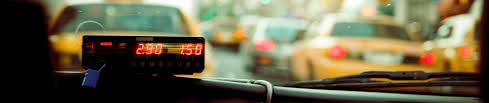

In [15]:
from IPython.display import Image
Image(filename="taxi_fare_image.jpg", width=900, height=1000)

#  <font color=maroon> Presentation outlines</font> 
- Introduction, data access and download- presented by <font color=orange>Shohidul Haque</font>

- Data preprocessing - presented by <font color=orange>Zahidul Khan</font>

- Modelling and evaluation - presented by <font color=orange>Rabbil Bhuiyan</font>

- Modelling output in puhti CSC - presented by <font color=orange>Shohidul Haque</font>


#  <font color=blue>1. Introduction, data access and download</font> 

## <font color=orange>Introduction</font>
- NYC data consists of millions of rides from each month. 
- The data provide insight into traffic patterns, road blockage, or large-scale events in New York City. 
- The visibility of estimated fare and ride duration in advance is important at the advent of apps.
- Predicting fare and duration of a ride can help passengers and drivers in many ways e.g selecting optimal route.

## <font color=orange>Data access and download</font>
- puhti.csc.fi (wget command for coppying the data url)
- puhti.csc.fi (cat command for merging 84 files)
- csc.pouta.fi (moving data using allas module)
- csc.rahti.fi (running jupyter notebook with subset data)

In [ ]:
#Importing necessary Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

In [163]:
# Reading data
df= pd.read_csv("https://a3s.fi/swift/v1/AUTH_f8a5dbc8033343aea820c139245afe13/haque_container/tlc_2019/yellow_tripdata_2019-01.csv", nrows=100000)

In [164]:
# Dataframe look like
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [165]:
df.shape

(100000, 18)

#### Aim : Developing machine learning model to predict the taxi fare in New York city
 
- As the amount of taxi fare is dependent on total distance (per km basis ) and total duration (per minute basis).
- we will use these variables as feature variables, while taxi fare would be response variable.

#  <font color=blue>2. Data pre-processing</font> 

In [166]:
# Calculate trip_duration in minutes based on the pickup and dropoff data
# Here we also convert the columns (datetime) into to_datetime

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()/60

In [167]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'trip_duration'],
      dtype='object')

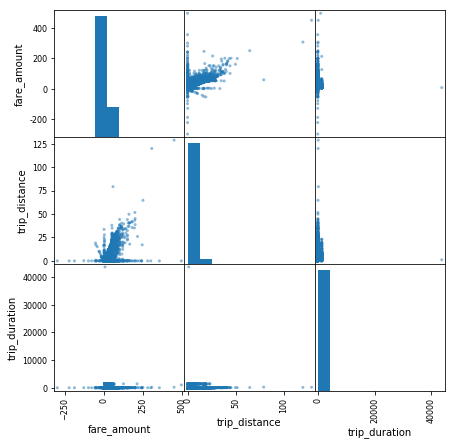

In [168]:
# Visualise the columns to be used for simple model
# we have chosen our few vairables as simple intution

pd.plotting.scatter_matrix(frame = df[['fare_amount', 'trip_distance', 'trip_duration']], figsize=(7,7))
plt.show()

- As can be seen from the chart, there are some outliers for all three variables. 
- Let’s perform an outlier removal and plot again.
- For example we observed that fare amount is high even with zero trip distance, so need to work with these outliers.

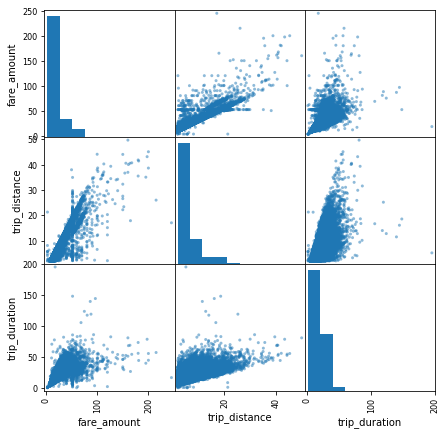

In [170]:
# Remove the outliers

df_filtered = df[(df['trip_distance'] >= 2) & (df['trip_distance'] <= 50) &\
                 (df['fare_amount'] >= 3) & (df['fare_amount'] <=300) & \
                 (df['trip_duration'] <= 200) & (df['trip_duration'] > 1)].copy()

# Visualise the columns to be used for simple intuitive model
pd.plotting.scatter_matrix(frame = df_filtered[['fare_amount', 'trip_distance', 'trip_duration']], figsize=(7,7))
plt.show()

- Here we see that there is a strong correlation between fare amount to both the trip distance and the trip duration. 
- We can build our model on those variables.

- We have also checked the importance of these variables using correlation matrix as below

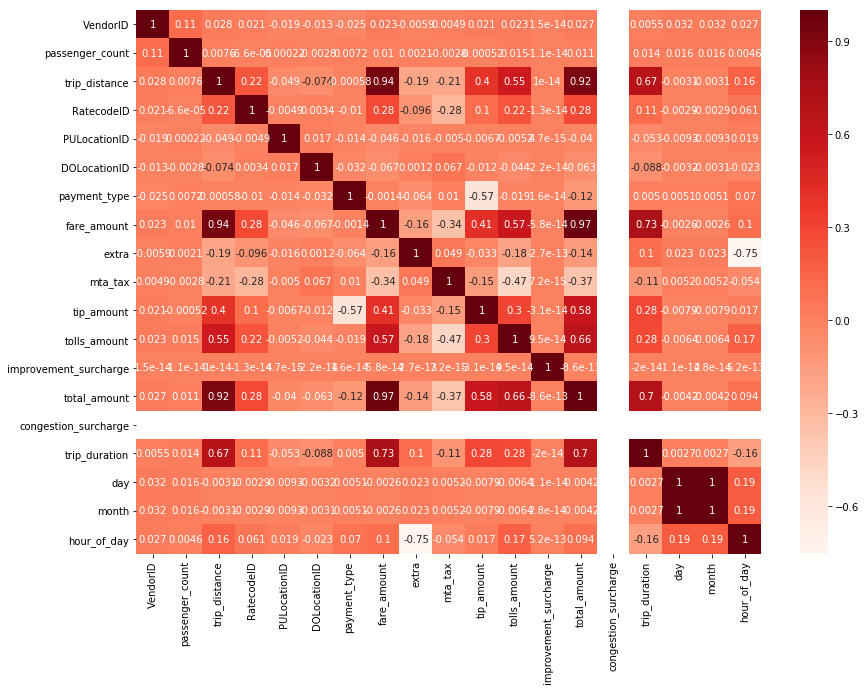

In [220]:
# Extraction of important features using Pearson Correlation matrix
import seaborn as sns
plt.figure(figsize=(14,10))
cor = df_filtered.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

- Here we see that trip distance and trip duration variables are important for predicting the fare amount due to higher correlation cofficient (0.94 and 0.73 respectively)

#  <font color=blue>3. Modelling and evaluation</font> 

- Building a function to calculate some statistics for the predictive power of the model
- First one is Root Mean Square Error (RMSE): the standard deviation of the difference between actual fare_amount and predicted fare_amount in $ (mean_squared_error)
- Second one is R-square: percentage of the actual fare_amount’s variation that is predicted by the model (r2_score)


In [ ]:

def model_results(X_train, X_test, y_train, y_test, model):
    """Print model parameters of RMSE and R-square on training and testing sets.
    """
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print("----Training Data results ----")
    print("RMSE: ${:.1f}".format(mean_squared_error(y_train, y_train_pred)**0.5))
    print("R2: {:.2f}\n".format(r2_score(y_train, y_train_pred)))
    
    print("----Test Data results ----")
    print("RMSE: ${:.1f}".format(mean_squared_error(y_test, y_test_pred)**0.5))
    print("R2: {:.2f}\n".format(r2_score(y_test, y_test_pred)))

In [173]:
# Spliting the data into training and test dataset
y = df_filtered[['fare_amount' ]]
X = df_filtered[['trip_distance', 'trip_duration']]

In [174]:
# Create Train and Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

# Simple bivariate model
from sklearn.linear_model import LinearRegression
clf=LinearRegression()
lm=clf.fit(X_train, y_train)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [175]:
model_results(X_train, X_test, y_train, y_test, lm)

----Training Data results ----
RMSE: $3.8
R2: 0.91

----Test Data results ----
RMSE: $3.5
R2: 0.92



- The testing dataset has an RMSE of $3.5 and we shall use this as our baseline score. 
- Now, let us try to improve this score.


## <font color=orange>Feature Engineering</font>

- Let's add more features to the model by the process of feature engineering.Thinking deeper !
- Pickup day of the week and hour of the day could play an important role in demand and traffic conditions and 
may impact on fare.

In [178]:
#Creating new features:
# e.g Pickup month
# e.g Pickup day of the week
# e.g Pickup hour of the day

df_filtered['day'] = df_filtered['tpep_pickup_datetime'].dt.day
df_filtered['month'] = df_filtered['tpep_pickup_datetime'].dt.month
df_filtered['day_of_week'] = df_filtered['tpep_pickup_datetime'].dt.weekday_name
df_filtered['hour_of_day'] = df_filtered['tpep_pickup_datetime'].dt.hour

# Check for any missing data
df_filtered.isna().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count              0
trip_distance                0
RatecodeID                   0
store_and_fwd_flag           0
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     50548
trip_duration                0
day                          0
month                        0
day_of_week                  0
hour_of_day                  0
dtype: int64

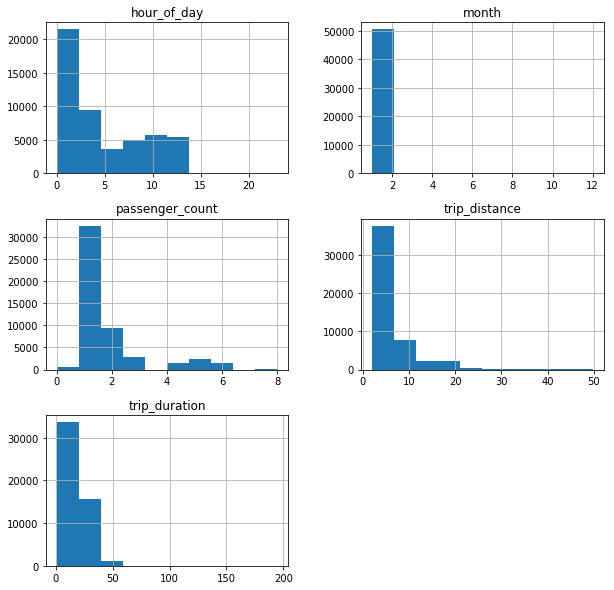

In [181]:
# Split response (y) and features (X)
y = df_filtered[['fare_amount']]
X = df_filtered[[ 'passenger_count','trip_distance', 'trip_duration', 'month', 'day_of_week', \
                 'hour_of_day']]

#since the columns like month, day_of_week, hour_of_day are categorical, let’s encode by get_dummies method.
# Encode the categorical variables
X_encoded = pd.get_dummies(X, columns=['month', 'day_of_week', 'hour_of_day'])

# Check distribution of features
X.hist(figsize = (10,10));

In [182]:
# Now again fit a simple Linear Regression model(after adding more features)
# Split Training and Testing sets
X_train, X_test,y_train, y_test = train_test_split(X_encoded, y)

# Multivariate Linear Model
lm = LinearRegression().fit(X_train,y_train)
model_results(X_train, X_test,y_train, y_test, lm)

----Training Data results ----
RMSE: $3.6
R2: 0.92

----Test Data results ----
RMSE: $4.3
R2: 0.89



- the model has better RMSE on training dataset but bit worse RMSE on test dataset indicating that the model is overfitting. 
- So here we will apply a regularization technique.

In [186]:
# regularization
# Lasso Regression to regularize

from sklearn.linear_model import Lasso

las = Lasso().fit(X_train,y_train)
model_results(X_train, X_test,y_train, y_test, las)

----Training Data results ----
RMSE: $3.8
R2: 0.91

----Test Data results ----
RMSE: $3.7
R2: 0.91



- Ok that’s better from an over-fitting perspective. 
- Let us now try hyper-parameter tuning to improve the model RMSE.
-  Here we used two methods for tunning
    - Sklearn's generic GridSearchCV
    - Sklearn's own LassoCV

### <font color=orange>GridSearchCV for hyperparameter tuning</font>

In [ ]:
# Lasso Regression Hyperparameter tuning
import time

alphas = np.logspace(-4, -0.5, 30)
n_folds = 5

lasso_params = {'alpha': alphas}

# GridSearch CV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

start = time.time()
las_tuned = GridSearchCV(Lasso(max_iter = 10000, random_state = 0), lasso_params, cv = n_folds)
las_tuned.fit(X_train, y_train)
end = time.time()
print('GridSearchCV execution time: {}'.format(end - start))

In [190]:
print('Lasso best params: {}\n'.format(las_tuned.best_params_))
model_results(X_train, X_test, y_train, y_test, las_tuned)

Lasso best params: {'alpha': 0.0037065129109221566}

----Training Data results ----
RMSE: $3.8
R2: 0.91

----Test Data results ----
RMSE: $3.7
R2: 0.92



- However, the GridSearchCV method took 59334 seconds (about 16 hours) to run
- Let’s see if LassoCV can run faster 

### <font color=orange>LassoCV for hyperparameter tuning</font>

In [192]:
# LassoCV for hyperparameter tuning
from sklearn.linear_model import LassoCV

# LassoCV for hyperparameter tuning
start = time.time()
las_cv = LassoCV(cv = n_folds, alphas = alphas, max_iter = 10000, random_state = 0)
las_cv.fit(X_train,y_train)
end = time.time()
print('LassoCV execution time: {}'.format(end - start))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV execution time: 244.15049624443054


- Yes here the execution time is less (244 seconds) and we can also compare the results.

In [194]:
print('LassoCV best params: {}\n'.format(las_cv.alpha_))
model_results(X_train, X_test,y_train, y_test, las_cv)

LassoCV best params: 0.0037065129109221566

----Training Data results ----
RMSE: $3.8
R2: 0.91

----Test Data results ----
RMSE: $3.7
R2: 0.92



- LassoCV give us the same best alpha of 0.003
- The best test score RMSE we can achieve here is $3.7

- This is just $0.2 higher than the RMSE of our simple initial model and can be well comparable.

- So, the LassoCV works well in predicting the taxi fare in our analysis
- However, we can try more complex model like Random Forest, Gradient Boosting or even a Neural Network
- We just here applied the Random Forest model to comapre as below

In [196]:
# Using RandomForest regression model 
from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)# Train the model on training data
rf.fit(X_train, y_train)

model_results(X_train, X_test, y_train, y_test, rf)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


----Training Data results ----
RMSE: $1.4
R2: 0.99

----Test Data results ----
RMSE: $3.7
R2: 0.91



- Here the training accuracy is high but the test data accuracy is not better compared to Lasso regression.

### <font color=orange>Visually checking correlation</font>

Text(0, 0.5, 'Actual Fare ($)')

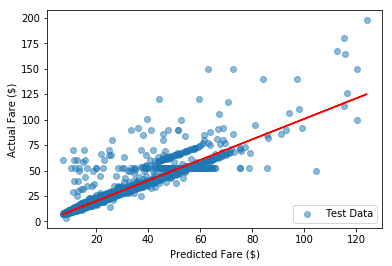

In [199]:
# Plot the Actual vs Predicted fare for LassoCV to visually check the correlation
y_train_pred = las_cv.predict(X_train)
y_test_pred = las_cv.predict(X_test)
test_data_fit = LinearRegression().fit(y_test_pred.reshape(-1, 1),y_test)
slope = test_data_fit.coef_[0]
intercept = test_data_fit.intercept_
line = slope * y_test_pred + intercept

#plt.scatter(y_train_pred, y_train, alpha = 0.2, label = 'Training Data (2015)')
plt.scatter(y_test_pred, y_test, alpha = 0.5, label = 'Test Data')
plt.plot(y_test_pred, line, 'r')
plt.legend(loc = 'lower right')
plt.xlabel('Predicted Fare ($)')
plt.ylabel('Actual Fare ($)')

#  <font color=blue>4. Modelling and evaluation at puhti</font> 
- We were able to build the model successfully <font color=blue>but with subset of data</font> 
- Now as a data scientist we aim to run the model in supercomputer (puhti supercomputer)
- Here, instead of subset (small dataset), we applied whole dataset and limited to 1 million observation
- We observed that the model output (LassoCV) is pretty good with high accuracy (R-squared as 0.92)
- Finally we can say, we are sucessfull. 
- <font color=orange>We are now professional data scientist !</font>

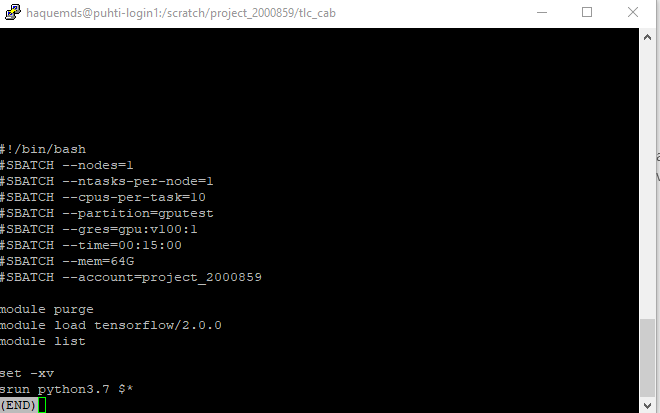

In [10]:
# Puhti sbatch command 
Image(filename="image2.png")

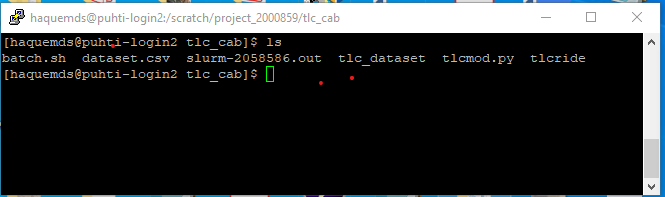

In [18]:
# The dataset and model notebook (tlcmod.py) in puhti supercomputer
# The full dataset is dataset.csv
# The model notebook is tlcmod.py
# The model output is slurm-2058586.out
Image(filename="image.png")

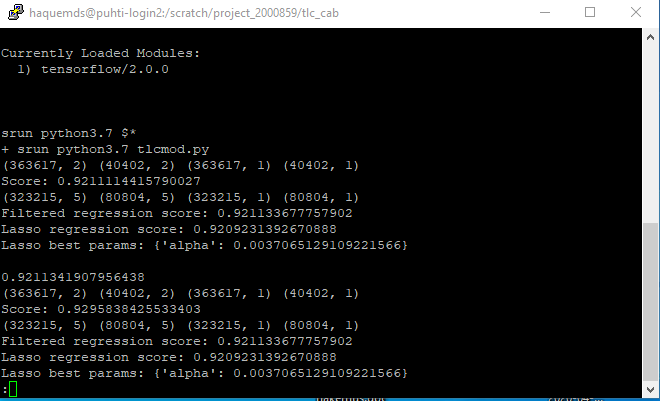

In [19]:
# The output of our model after running at Puhti server (slurm-2058586.out)
Image(filename="image1.png")

- We observed the almost same output with R-squared as 0.92 and alpha as 0.003
- At this stage we are successfull running and analyzing big data using puhti server (super computer)

# <font color=orange>         THANK YOU !    </font>



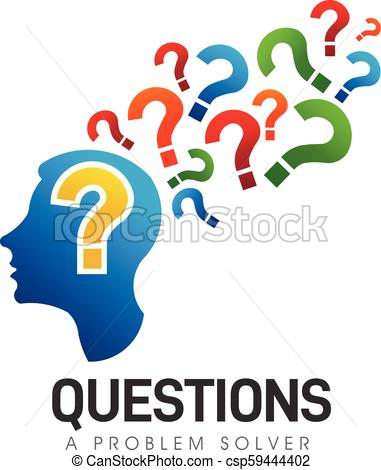

In [12]:
Image(filename="questions_image.jpg", width=500, height=500)